In [13]:
""" simple thermal evolution model, mantle and core """

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from collections import Iterable
import six
import math
from IPython.display import display, Math
import pandas as pd

In [14]:
""" universal constants """

M_E = 5.972e24 # earth mass in kg
R_E = 6371e3 # earth radius in m
L_sun =  3.9e26 # solar luminosity in W
#Q_cmb_Earth = 11e12 # heat flux from (Earth's) core in W
years2sec = 31557600
AU2m = 1.5e11
sb = 5.67e-8 # Stefan Boltzmann constant in W m^-2 K^-4
R_b = 8.3144598 # universal gas constant in J mol −1 K −1

# Half-lives in years from Dye (2012) in Treatise on Geophys
t_40K_half = 1.26e9 
t_235U_half = 7.04e8 
t_238U_half = 4.46e9
t_232Th_half = 1.4e10

# Heating rates of radioisotopes per mass of isotope in W kg^-1 from Dye (2012) in Treatise on Geophys
h_40K_0 = 28.47e-6
h_235U_0 = 568.47e-6
h_238U_0 = 95.13e-6
h_232Th_0 = 26.3e-6

# radioisotope abundances
# TODO: are the below values in moles or mass? 
K_0 = 0.0117e-2 # ratio of 40-K to total K at time 0 (in Treatise on Geophysics)
U_0_235 = 0.0072 # ratio of 235-U to total U at time 0 (in Treatise on Geophysics)
U_0_238 = 0.9927 # ratio of 238-U to total U at time 0 (in Treatise on Geophysics)
Th_0 = 1 # ratio of 232-Th to total Th at time 0 (in Treatise on Geophysics)
H_0 = [h_40K_0, h_235U_0, h_238U_0, h_232Th_0]
el_0 = [K_0, U_0_235, U_0_238, Th_0]
t_half = [t_40K_half, t_235U_half, t_238U_half, t_232Th_half]

In [15]:
"""surface/space interface"""

def luminosity(tau, L=None, **kwargs):
    return L
    
def q_star(t=None, Alb=None, a=None, **kwargs):
    """Calculate incident stellar flux density (over entire heliocentric sphere with radius a) in W m^-2"""
    return luminosity(t, **kwargs)*(1-Alb)/(4*np.pi*a**2) # 4pi is the total solid angle subtended by a sphere

def q_sfc_outgoing(R_p=None, SA_p=None, **kwargs):
    return q_star(**kwargs)*(np.pi*R_p**2)/SA_p # assume no geothermal contribution, pi*R^2 cancels out

def T_sfc(q_out=None, **kwargs):
    """Calculate equilibrium surface temperature given outgoing radiation in W m^-2"""
    return (q_out/sb)**(1/4)

In [16]:
"""geometry"""

def SA(M=None, rho=None, R=None, V=None):
    if R is None:
        if (V is None) and (M is not None) and (rho is not None):
            V = vol(M, rho)
        else:
            print('Missing mass or density to calculate volume')
        R = radius(V)
    return 4*np.pi*R**2

def radius_by_vol(V):
    return (3*V/(4*np.pi))**(1/3)

def radius_seager(M_p, CMF=0.3, k1=-0.20945, k2=0.0804, k3=0.394, m1=None, r1=None):
    if (m1 is None) and (r1 is None):
        if CMF==0.3:
            m1 = 6.41*M_E
            r1 = 2.84*R_E
        elif CMF==0.675:
            m1 = 6.41*M_E
            r1 = 3.19*R_E
        elif CMF==0: # all perovskite
            m1 = 7.38*M_E
            r1 = 3.58*R_E
    M_s = M_p/m1
    R_s = 10**(k1 + 1/3*np.log10(M_s) - k2*M_s**k3)
    return R_s*r1

def radius_otegi(M_p):
    return np.exp(1/3.45*np.log(M_p/0.9))

def radius_zeng(M_p, CMF=None):
    # applicable to M_E <= 8 and CMF <= 0.4
    print('using Zeng radius model')
    return (1.07 - 0.21*CMF)*(M_p/M_E)**(1/3.7)

def vol(M, rho):
    try:
        return M/rho
    except TypeError:
        return np.array(M)/np.array(rho)
    
def grav(M, R):
    """Calculate acceleration due to gravity on a point mass in m s^-2"""
    return 6.674e-11*M/R**2

In [205]:
"""thermodynamics"""

def thermal_diffusivity(k, rho, C_p):
    """
    Calculate thermal diffusivity
    
    Parameters
    ----------
    k : Thermal conductivity
    C_p : Specific heat capacity in J K^-1 kg^-1
    rho : density in kg m^-3
    """
    return k/(rho*C_p)

def nu_Driscoll(T, nu_0=7e7, Ea=3e5, **kwargs):
    """kinematic viscosity (upper mantle) from eqn 6 in Driscoll & Bercovici"""
    return nu_0*np.exp(Ea/(R_b*T))/10

def nu_Dorn(T, nu_0=1.6e20, Ea=300e3, T_0=1800, **kwargs):
    # viscosity (below lithosphere) from Dorn, Noack & Rozal 2018
    return nu_0*np.exp(Ea/R_b*(T**-1-T_0**-1))

def nu_KW(T, p=0, **kwargs): # Karato & Wu 1993, diffusion law for dry olivine
    return 2.6e10*np.exp((3e5 + (6e3*p))/(R_b*T))   

def eta_Thi(T, eta_0=1e21, T_ref=1600, Ea=300e3, **kwargs): # diffusion creep, dry rheology (Thiriet+ 2019)
    return eta_0*np.exp(Ea/R_b*(T**-1 - T_ref**-1))

def adiabat(T_0, R=None, g=None, R_p=None, h=None, c_v=None, alpha_m=None, adiabatic=True, **kwargs):
    if adiabatic:
        R_0 = R_p - 0.5*h # depth to avg mantle temp (taken to be midpoint between surface and cmb)
        u = np.exp(-(R - R_0)*alpha_m*g/c_v) # page 39 driscoll & bercovici 2014
        #print('adiabatic T decrease', u)
        return u*T_0
    else:
        return T_0

def Ra(nu=None, eta=None, kappa=None, alpha=None, rho=None, g=None, deltaT=None, l=None):
    if (nu is None) and (eta is not None):
        return rho*alpha*deltaT*l**3*g/(kappa*eta)
    elif (nu is not None) and (eta is None):
        return alpha*deltaT*l**3*g/(kappa*nu)
    
def sph_conduction(r, k_m=None, T_l=None, T_s=None, R_p=None, R_l=None,
                   a0=None, **kwargs):
    c1 = k_m*(T_l - T_s - a0/(6*k_m)*(R_p**2 - R_l**2))/(R_l**-1 - R_p**-1)
    c2 = T_s + a0/(6*k_m)*R_p**2 - c1/(k_m*R_p)
    return -a0/(6*k_m)*r**2 + c1/(k_m*r) + c2

def sph_flux(r, a0=None, k_m=None, T_l=None, T_s=None, R_p=None, R_l=None, **kwargs):
    c1 = k_m*(T_l - T_s - a0/(6*k_m)*(R_p**2 - R_l**2))/(R_l**-1 - R_p**-1)
    return a0/3*r + c1/r**2 # for r>0 in m

def rect_flux(r, a0=None, q0=None, r0=None, **kwargs):
    c0 = q0 - a0*r0
    return a0*r + c0

def sfc_flux(q_bl=None, R_p=None, R_l=None, m=2, **kwargs):
    return q_bl/((R_p/R_l)**m)

In [206]:
""" topography """

def dyn_topo(F, rho_m=None, rho_w=1000, alpha_m=None, eta_m=None, kappa_m=None, g_sfc=None, 
             k_m=None, C=5.4, **kwargs):
    return C*rho_m/(rho_m-rho_w) * ((alpha_m*F*eta_m*kappa_m)/(rho_m*g_sfc*k_m))**(1/2) # eqn 33 Parsons & Daly

In [270]:
"""stagnant lid thermal model adapted from Thiriet+ 2019"""

def init(k_m=None, rho_m=None, rho_c=None, c_m=None, CMF=None, M_p=None, R_p0=None, R_c0=None, **kwargs):
    if R_p0 is None:
        R_p = radius_zeng(M_p, CMF)*R_E # in m
    else:
        R_p = R_p0
    if R_c0 is None:
        M_m = M_p*(1 - CMF) # mass of mantle
        CRF = CMF**0.5 # Zeng & Jacobsen 2017
        M_c = M_p*CMF # M_p - M_m
        R_c = R_p*CRF
        #R_c = radius_seager(M_p*CMF, CMF=0, m1=4.34*M_E, r1=2.23*R_E) # EoS for iron... is this consistent?
    else:
        R_c = R_c0
        CRF = R_c0/R_p0
        M_c = 4/3*np.pi*R_c**3 * rho_c
        CMF = M_c/M_p
        M_m = 4/3*np.pi*(R_p**3 - R_c**3)*rho_m  #M_p - M_c
    SA_p = SA(R=R_p)
    SA_c = SA(R=R_c) # core surface area 
    h = R_p - R_c # mantle thickness
    g_sfc = grav(M_p, R_p)
    if CMF>0:
        g_cmb = grav(M_c, R_c)
    else:
        g_cmb = 0
    kappa_m = thermal_diffusivity(k_m, rho_m, c_m)
    return dict(kappa_m=kappa_m, SA_p=SA_p, SA_c=SA_c, M_m=M_m, g_sfc=g_sfc, R_p=R_p, R_c=R_c,
                CRF=CRF, g_cmb=g_cmb, h=h, M_c=M_c)

def dyn_visc(T=None, nu_0=None, visc_type=None, rho_m=None, **kwargs):
    if visc_type=='constant':
        return nu_0*rho_m
    elif visc_type=='Dorn':
        return nu_Dorn(T, **kwargs)*rho_m
    elif visc_type=='KW':
        return nu_KW(T, **kwargs)*rho_m
    elif visc_type=='Driscoll':
        return nu_Driscoll(T, **kwargs)*rho_m
    elif visc_type=='Thi':
        return eta_Thi(T, **kwargs)

def bdy_thickness_beta(dT=None, R_l=None, R_c=None, Ra_crit=None, Ra_rh=None, beta=None, g=None,
                  kappa_m=None, eta_m=None, Ea=None, alpha_m=None, rho_m=None, a_rh=None,**kwargs):
    """Thickness of thermal boundary layer """
    return (R_l - R_c) * (Ra_crit/Ra_rh)**beta
    
def bdy_thickness(dT=None, Ra_crit=None, g=None, kappa_m=None, eta_m=None, alpha_m=None, rho_m=None, 
                  **kwargs):
    """Thickness of thermal boundary layer """
    return (Ra_crit*kappa_m*eta_m/(alpha_m*rho_m*g*dT))**(1/3)

def inv_bdy_thickness(dT=None, Ra_crit=None, g=None, kappa_m=None, eta_m=None, alpha_m=None, rho_m=None, 
                  **kwargs):
    """Thickness of thermal boundary layer """
#     print(alpha_m*rho_m*g*dT)
#     print((Ra_crit*kappa_m*eta_m))
#     print('a;pha', alpha_m, 'rho_m', rho_m, 'g', g, 'dT', dT, 'Ra_crit', Ra_crit, 'kappa', kappa_m, 'eta', eta_m)
    return ((alpha_m*rho_m*g*np.absolute(dT))/(Ra_crit*kappa_m*eta_m))**(1/3)
    
def h_rad_old(t=None, H_0=None, X_0=None, el_0=None, t_half=None, t_vect=False, **kwargs):
    """Calculate radiogenic heating in W kg^-1"""
    if not t_vect:
        return sum(H_0*X_0*el_0*np.exp(-np.log(2)*t/t_half))
    else:
        # for a list of ages
        h = np.zeros(len(t))
        for ii, val in enumerate(t):
            h[ii] = sum(H_0*X_0*el_0*np.exp(-np.log(2)*val/t_half))
        return h
    
def h_rad(t, tf=None, H_0=None, c_n=None, p_n=None, lambda_n=None, t_vect=False, **kwargs):
    """Calculate radiogenic heating in W kg^-1 from Korenaga (2006)"""
    x_n = np.array(c_n)*np.array(p_n)
    x_tot = sum(x_n)
    h_n = x_n/x_tot
    
    try:
        h = H_0*sum(h_n*np.exp(lambda_n*(tf-t)))
    except ValueError:
        # for a list of ages
        h = np.zeros(len(t))
        for ii, t_val in enumerate(t):
            h[ii] = H_0*sum(h_n*np.exp(lambda_n*(tf-t_val)))
    return h
        
def H_rad(t=None, M=None, **kwargs):
    """Calculate energy flux radioisotope decay in W"""
    h = h_rad(t, **kwargs)
    return h*M # mass cancels out

def q_bl(deltaT, k=None, d_bl=None, beta=None, d_bl_inv=None, **kwargs):
    if d_bl_inv is None:
        
        return k*deltaT/d_bl #a_BL*Ra_rh**beta_BL * k*deltaT/h
    else:
        return k*deltaT*d_bl_inv

def Q_bl(q=None, deltaT=None, SA=None, h=None, d_bl=None,
         adiabatic=False, beta=None, Ra_rh=None, **kwargs):
    """Calculate energy flux from conduction across thermal bdy layer in W""" 
    if q is None:
        return SA*q_bl(deltaT, k=k, d_bl=d_bl, beta=beta, **kwargs)
    else:
        return SA*q

def T_lid(T_m, a_rh=None, Ea=None, **kwargs):
    return T_m - a_rh*(R_b*T_m**2/Ea) # temperature at base of stagnant lid, Thiriet+ eq. 15

def lid_growth(T_m=None, q_ubl=None, h0=None, R_p=None, R_l=None, T_l=None, rho_m=None, T_s=None,
               c_m=None, k_m=None, **kwargs):
    
    a0 = h0*rho_m # radiogenic heating in W/m^3
    c1 = k_m*(T_l - T_s - a0/(6*k_m)*(R_p**2 - R_l**2))/(R_l**-1 - R_p**-1)
#     return (-q_ubl + a0*R_l + k_m*(T_l - T_s - (a0/(2*k_m)*(R_p**2 - R_l**2)))/(R_p-R_l))/(rho_m*c_m*(T_m - T_l)) # 1D rectangular
    return (-q_ubl + a0/3*R_l + c1/R_l**2)/(rho_m*c_m*(T_m - T_l)) # spherical

def dTdt(t, y, M_c=None, c_m=None, c_c=None, SA_c=None, adiabats=0, **kwargs):
    """R.H.S. of ODE for mantle temperature change"""
    #print('t, T', t, T)
    T_m = y[0]
    T_c = y[1]
    D_l = y[2]
    
    R_l, T_l, eta_m, eta_cmb, nu_m, nu_cmb, TBL_u, h_rad_m, q_ubl, Q_ubl, Ra_i, Ra_crit_c, TBL_c, q_core, Q_core, M_mi, H_rad_m, a0, H_rad_lid, q_sfc, Q_sfc = outputs(t, T_m=T_m, T_c=T_c, D_l=D_l, M_c=M_c, c_m=c_m, SA_c=SA_c, **kwargs)

    if SA_c>0:
        dTdt_c = -Q_core/(M_c*c_c)
    else:
        dTdt_c = 0
    dTdt_m = (-Q_ubl + H_rad_m + Q_core)/(M_mi*c_m)
    dDdt = lid_growth(T_m=T_m, q_ubl=q_ubl, h0=h_rad_m, R_l=R_l, T_l=T_l, c_m=c_m, **kwargs)
    return [dTdt_m, dTdt_c, dDdt]

def solve_Tm(tf=None, T_m0=None, T_c0=None, D_l0=None, t0=0, plots=False, plots_save=False, fend='', 
             M_p=None, T_s=None, names=None, compare_dir=None, plot_snapshots=[0], **kwargs):
    derargs = init(M_p=M_p, **kwargs)
    if T_s is None:
        q_out = q_sfc_outgoing(**derargs, **kwargs)
        T_s = T_sfc(q_out)
    f = integrate.solve_ivp(fun=lambda t, y: dTdt(t, y, **dict(T_s=T_s, M_p=M_p, tf=tf,
                                                  **derargs, **kwargs)), 
                            t_span=(t0,tf), y0=[T_m0, T_c0, D_l0], max_step=100e6*years2sec,
                            method='RK45', t_eval=None, dense_output=False, events=None)
    if plots:
        plot_output(f, names, 2, plots_save=plots_save, **dict(T_s=T_s, M_p=M_p, tf=tf), compare_dir=compare_dir,
                    plot_snapshots=plot_snapshots, **derargs, **kwargs)
    return f

def outputs(t=None, T_m=None, T_c=None, D_l=None, T_s=None, M_m=None, M_c=None, c_m=None, c_c=None, 
            SA_p=None, SA_c=None, g_sfc=None, g_cmb=None, R_p=None, R_c=None, k_m=None, k_lm=None, 
            Ra_crit_u=None, beta_u=None, beta_c=None, rho_lith=None, adiabats=0, **kwargs):
    R_l = R_p - D_l
    T_l = T_lid(T_m, **kwargs)
    V_lid = 4/3*np.pi*(R_p**3 - R_l**3)
    M_lid = V_lid*rho_m # should use another density?
    M_mi = M_m - M_lid
    if (beta_u is None) or (beta_c is None):
        h = None
    else:
        pass
    eta_m = dyn_visc(T=T_m, **kwargs)
    eta_cmb = dyn_visc(T=(T_c+T_m)/2, **kwargs)
    nu_m = eta_m/rho_m
    nu_cmb = eta_cmb/rho_m
#     g_l = grav(M_p - M_lid, R_l)
#     Ra_rh = Ra(eta=dyn_visc(T=T_l, **kwargs), kappa=kwargs['kappa_m'], alpha=kwargs['alpha_m'], 
#                rho=rho_m, g=g_sfc, deltaT=T_m-T_l, l=R_l-R_c)
    TBL_u = bdy_thickness(dT=T_m-T_l, eta_m=eta_m, g=g_sfc, Ra_crit=Ra_crit_u, **kwargs)
    h_rad_m = h_rad(t, **kwargs) # W kg^-1
#     if t==0:
#          print('k=',k_m, 'dT=',T_m-T_l, 'd_bl=',TBL_u)
    q_ubl = q_bl(deltaT=T_m-T_l, k=k_m, d_bl=TBL_u, beta=beta_u, **kwargs)
    Q_ubl = Q_bl(q_ubl, SA=4*np.pi*R_l**2) 
    Ra_i = Ra(eta=eta_m, kappa=kwargs['kappa_m'], alpha=kwargs['alpha_m'], rho=rho_m, 
              g=g_sfc, deltaT=T_m-T_l, l=R_l-R_c)
    Ra_crit_c = 0.28*Ra_i**0.21  
    
    if SA_c>0:
        TBL_c_inv = inv_bdy_thickness(dT=T_c-T_m, eta_m=eta_cmb, g=g_cmb, Ra_crit=Ra_crit_c, **kwargs)  
        q_core = q_bl(deltaT=T_c-T_m, k=k_lm, d_bl_inv=TBL_c_inv, beta=beta_c, **kwargs)
        Q_core = Q_bl(q_core, SA=SA_c) #Q_bl(deltaT=T_c-T_m, k=k_lm, SA=SA_c, d_BL=TBL_c,a_BL=a_BL_c, beta_BL=beta_BL_c, Ra_rh=Ra_Rh_c, **kwargs) # core flux in W
        TBL_c = TBL_c_inv**-1
    else:
        TBL_c=None
        Q_core = 0

    H_rad_m = H_rad(t, M=M_mi, **kwargs) # mantle radiogenic heating in W
    a0 = h_rad_m*rho_m
    H_rad_lid = H_rad(t, M=M_lid, **kwargs)
    
    q_sfc = sfc_flux(q_bl=q_ubl, R_p=R_p, R_l=R_l, m=2, **kwargs)
    #q_sfc = sph_flux(R_p, a0=a0, T_l=T_l, R_l=R_l, k_m=k_m, T_s=T_s, R_p=R_p, **kwargs) # surface heat flux in W m^-2
    #q_sfc = rect_flux(R_p, a0=a0, q0=None, r0=None, **kwargs)
    Q_sfc = q_sfc*4*np.pi*R_p**2
    return R_l, T_l, eta_m, eta_cmb, nu_m, nu_cmb, TBL_u, h_rad_m, q_ubl, Q_ubl, Ra_i, Ra_crit_c, TBL_c, q_core, Q_core, M_mi, H_rad_m, a0, H_rad_lid, q_sfc, Q_sfc


In [271]:
""" plotting """
def plot_output(f, names, ncols=6, plots_save=False, verbose=True, compare_dir=None, plot_snapshots=[0], **kwargs):
    
    T_m = f.y[0]
    T_c = f.y[1]
    D_l = f.y[2]
    R_l, T_l, eta_m, eta_cmb, nu_m, nu_cmb, TBL_u, h_rad_m, q_ubl, Q_ubl, Ra_i, Ra_crit_c, TBL_c, q_core, Q_core, M_mi, H_rad_m, a0, H_rad_lid, q_sfc, Q_sfc = outputs(t=f.t, T_m=T_m, T_c=T_c, D_l=D_l, **kwargs)
    urey = (H_rad_m + H_rad_lid)/Q_sfc
    
    for ii in plot_snapshots:
        plot_structure(T_m=T_m[ii], T_c=T_c[ii], R_l=R_l[ii], T_l=T_l[ii], h_rad_m=h_rad_m[ii],
                       d_lbl = TBL_c[ii], d_ubl = TBL_u[ii],
                       legsize=12, **kwargs)
    
    # scale for plotting
    h_rad_m = h_rad_m*1e12
    H_rad_m = H_rad_m*1e-12
    TBL_u = TBL_u*1e-3
    q_ubl = q_ubl*1e3
    D_l = D_l*1e-3
    Q_ubl = Q_ubl*1e-12
    q_sfc = q_sfc*1e3
    Q_sfc = Q_sfc*1e-12
    TBL_c = TBL_c*1e-3
    q_core = q_core*1e3
    Q_core = Q_core*1e-12
    
    nrows = int(np.ceil(len(names)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    
    out_vars = list(names.keys())
    ylabels = list(names.values())
    for jj in range(ncols):
        for ii in range(nrows):
            ax = axes[ii][jj]
            param = np.array(out_vars).reshape(nrows, ncols)[ii][jj]
            try:
                plot_one(ax, f.t*1e-9/years2sec, eval(param), 
                         '', np.array(ylabels).reshape(nrows, ncols)[ii][jj], lw=2)
            except ValueError:
                print('could\'t plot', param)
            if compare_dir is not None: 
                try: # if data exists to benchmark this param
                    df = pd.read_csv(compare_dir+'/'+param+'.csv', header=5, names=['time', 'value'],
                                    index_col=False)
                    plot_one(ax, df['time'], df['value'], 
                             '', np.array(ylabels).reshape(nrows, ncols)[ii][jj], c='r')
                    ax.legend(['this work', compare_dir], frameon=False)
                except IOError:
                    #print('file', str(compare_dir+'/'+param+'.csv'), 'not found')
                    pass

    plot_setxlabel(axes, 'Age (Gyr)', 'all')
    axes[0][0].set_title('%.2f'%(kwargs['M_p']/M_E)+' M$_E$, CMF='+str(CMF))
    plt.tight_layout()
    if plots_save:
        fig.savefig('figs/evol_M'+'%.2f'%(M_p/M_E)+'_CMF'+str(CMF)+'.png', bbox_inches='tight') 
    if verbose:
        print('n timesteps =', len(f.t))
        print('$t_f$ =', f.t[-1]/(1e9*years2sec), 'Gyr')
        print(r'$R_p$ =', '%.2f'%(kwargs['R_p']/R_E), 'R_E =', '%.2f'%(kwargs['R_p']*1e-3), 'km')
        print(r'$R_c$ =', '%.2f'%(kwargs['CRF']*kwargs['R_p']*1e-3), 'km')
        print(r'$M_{m+lid}$ =', '%.2e'%(kwargs['M_m']), 'kg')
        print(r'$g_{sfc}$ =', '%.2f'%kwargs['g_sfc'], 'm s^-2')
        print(r'$g_{cmb}$ =', '%.2f'%kwargs['g_cmb'], 'm s^-2')
        print(r'$\kappa_m$', '%.6f'%kwargs['kappa_m'], 'm^2 s^-1')
        print(r'$SA_c$ =', '%.2f'%(kwargs['SA_c']/kwargs['SA_p']), 'x SA_p')
        print(r'CRF =', '%.2f'%kwargs['CRF'])
        print(r'$T_s$ =', '%.2f'%kwargs['T_s'], 'K')
        print(r'$h_0$ =', '%.2f'%(h_rad(0, **kwargs)*1e12), 'pW kg^-1')
        print(r'$h_{4.5}$ =', '%.2f'%(h_rad(4.5*1e9*years2sec, **kwargs)*1e12), 'pW kg^-1')
        print(r'$H_0$ =', '%.2f'%(H_rad_m[0] + H_rad_lid[0]), 'W')
        print(r'$H_{4.5}$ =', '%.2f'%(H_rad_m[-1] + H_rad_lid[-1]), 'W')
        print(r'viscosity method:', kwargs['visc_type'])
        print(r'Urey ratio @ $t_f$ =', '%.2f'%urey[-1])
        print('q_sfc(t=0)', '%.2f'%q_sfc[0], 'mW m^-3')
        print('D_l(t=0)', D_l[0])
        print('M_c', kwargs['M_c'], 'kg')
    
    return fig

def plot_structure(ax=None, T_m=None, T_c=None, R_p=None, R_l=None, R_c=None, T_l=None, h_rad_m=None,
                   d_lbl=None, d_ubl=None, 
                   labelsize=16, legsize=14, **kwargs):
    # plot temp structure (for a given time)
    r_c = np.linspace(0, R_c*1e-3)
    r_lbl = np.linspace(R_c*1e-3, (R_c+d_lbl)*(1e-3))
    r_m = np.linspace((R_c+d_lbl)*1e-3, (R_l-d_ubl)*1e-3) # radius for mantle in km
    r_ubl = np.linspace((R_l-d_ubl)*1e-3, (R_l)*1e-3)
    r_l = np.linspace(R_l*1e-3, R_p*1e-3) # radius for lid
    T_cond = sph_conduction(r_l*1e3, a0=h_rad_m*kwargs['rho_m'], T_l=T_l, R_p=R_p, R_l=R_l, **kwargs)
    q = sph_flux(r_l*1e3, a0=h_rad_m*kwargs['rho_m'], T_l=T_l, R_p=R_p, R_l=R_l, **kwargs)
        
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
#     y0 = mx0+c
#     c = y0 - mx0
    ax.plot(T_cond, r_l, c='xkcd:bluish purple')
    #ax.plot(d_ubl/(T_m-T_l)*(r_ubl-R_l) + T_l, r_ubl, c='xkcd:greenish')
    ax.plot([T_l, T_m], [R_l*1e-3, (R_l-d_ubl)*1e-3], c='xkcd:greenish', marker = None)
    ax.plot([T_m]*len(r_m), r_m, c='xkcd:greenish')
    ax.plot([T_m, T_c], [(R_c+d_lbl)*1e-3, R_c*1e-3], c='xkcd:greenish', marker = None)
    ax.plot([T_c]*len(r_c), r_c, c='xkcd:clay')
        
    ax.set_ylabel('Radius (km)', fontsize=labelsize)
    ax.set_xlabel('Temperature (K)', fontsize=labelsize)
    ax.set_ylim([0, R_p*1e-3])
#     #ax.fill_between(x=x, y0=[0]*len(x), y1=[R_cmb*1e-3]*len(x), color='xkcd:gold') # core
    ax.text(T_cond[-1], 0, 'Core', ha='left', va='bottom', fontsize=legsize, c='xkcd:clay')
#     #ax.fill_between(x=x, y0=[R_cmb*1e-3]*len(x), y1=[R_p*1e-3]*len(x), color='xkcd:tomato') # mantle
    ax.text(T_cond[-1], R_c*1e-3, 'Convecting region', ha='left', va='bottom', fontsize=legsize, c='xkcd:greenish')
    ax.text(T_cond[-1], R_l*1e-3, 'Lid', ha='left', va='bottom', fontsize=legsize, c='xkcd:bluish purple')
    
    ax2 = ax.twiny()
    ax2.set_xlabel('Flux (mW m$^{-2}$)', color='xkcd:grey')  
    ax2.plot(q*1e3, r_l, color='xkcd:grey')
    ax2.tick_params(axis='x', labelcolor='xkcd:grey')

    return ax

def plot_one(ax, x, y, xlabel, ylabel, labelsize=15, legsize=16, lw=1, ls='-', marker=None, 
             ms=5, c='k', text=None, xticks=True, ylim=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if not xticks:
        ax.set_xticks([])
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.plot(x, y, c=c, lw=lw, ls=ls, marker=marker, ms=ms)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

def plot_setxlabel(axes, label, style, labelsize=16):
    ny, nx = np.shape(axes) # assume 2D
    for ii, ax in enumerate(axes):
        for jj, a in enumerate(ax):
            if (style=='all') or ((style=='bottom') and (jj==ny-1)):
                a.set_xlabel(label, fontsize=labelsize)
            if (style=='bottom') and (jj<ny-1):
                a.set_xticks([])


In [272]:
""" default model input parameters """

L=1 # stellar luminosity in solar units
Alb=0 # planetary albedo
a = 1 # semimajor axis in au

Ra_crit = 660 # critical Rayleigh number (in Driscoll & Bercovici 2014)
rho_c = 8000 # Density of iron core in kg m^-3 
rho_m = 3300 #4500 # Density of silicate mantle in kg m^-3 
# what pressure should you take these densities at?
c_pm = 1200 # specific heat capacity from Dorn, Noack & Rozal 2018 in J kg−1 K−1 
#c_pm = 800 # specific heat capacity of silicate material (at constant volume) in J kg−1 K−1 (Elkins-Tanton+ 2011)
c_vc = 530 # speific heat capacity iron core Nimmo+ 1997
alpha_m = 4e-5 # Lees+2019 lithospheric mantle #2e-5 # thermal expansivity of silicate mantle in K^-1
k_m = 4 # thermal conductivity of silicate mantle in W m^−1 K^−1
k_lm = 10 # thermal conductivity lower mantle in W m^−1 K^−1 from Driscoll & Bercovici
#dT_core = 1000 # temperature jump across CMB in K
beta = 1/3 # Nusselt exponent
eta_m0 = 2.8e20 # Lees+ 2019

X_K = 250 # initial abundance of K in wt ppm (in Treatise on Geophysics, think these are by weight but double check)
X_U = 2e-2# initial abundane of U in wt ppm ""
X_Th = 7e-2 # initial abundance of Th in wt ppm ""
X_0 = [X_K, X_U, X_U, X_Th]



n timesteps = 66
$t_f$ = 4.5 Gyr
$R_p$ = 0.53 R_E = 3400.00 km
$R_c$ = 1700.00 km
$M_{m+lid}$ = 5.04e+23 kg
$g_{sfc}$ = 3.69 m s^-2
$g_{cmb}$ = 3.42 m s^-2
$\kappa_m$ 0.000001 m^2 s^-1
$SA_c$ = 0.25 x SA_p
CRF = 0.50
$T_s$ = 250.00 K
$h_0$ = 22.18 pW kg^-1
$h_{4.5}$ = 4.00 pW kg^-1
$H_0$ = 3092898751646.97 W
$H_{4.5}$ = 516149300325.77 W
viscosity method: Thi
Urey ratio @ $t_f$ = 0.87
q_sfc(t=0) 6.95 mW m^-3
D_l(t=0) 300.0
M_c 1.4817258918803187e+23 kg


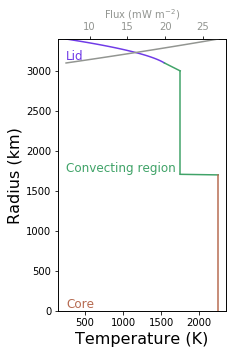

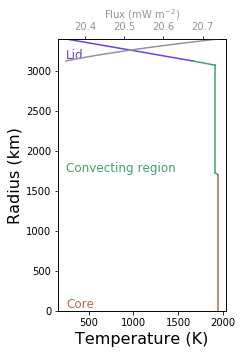

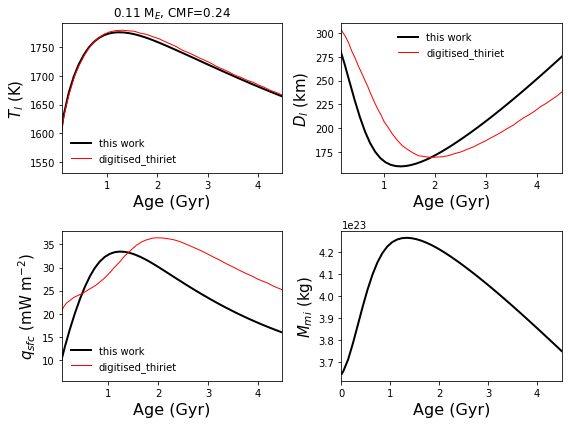

In [273]:
### """ reprouce Thiriet+ 2019 Mars1"""

R_p0 = 3400e3
R_c0 = 1700e3
Ra_crit = 450
T_m0 = 1750
T_c0 = 2250
D_l0 = 300e3 # 350e3 # 350 matches thiriet initial... initial lid thickness
rho_m = 3500
rho_c = 7200
rho_lith = 2800
c_m = 1142
c_c = 840
CMF = 0.24
M_p = 6.39e23/M_E # in M_E
beta_u = None # defaults to 1/3
beta_c = None # defaults to 1/3
a_rh = 2.44 #2.54 # they give results using 2.44 for beta=1/3
k_m = 4
k_lm = 4
alpha_m = 2.5e-5
T_s = 250
t_f = 4.5
# viscosity 
Ea = 300e3
eta_0 = 1e21
T_ref = 1600
X_K = 305 # initial abundance of K in wt ppm 
X_U = 16e-3 # initial abundane of U in wt ppm 
X_Th = 56e-3 # initial abundance of Th in wt ppm 
X_0 = [X_K, X_U, X_U, X_Th]
c_n = np.array([U_0_238, U_0_235, Th_0, K_0])*np.array([1, 1, X_Th/X_U, X_K/X_U]) # element abundance rel. to U
p_n = [9.37e-5, 5.69e-4, 2.69e-5, 2.79e-5] # heating per kg of isotope
lambda_n = np.array([0.155, 0.985, 0.0495, 0.555])*1e-9/years2sec # half life in sec
H_0 = 4e-12 # radiogenic heating in W/kg at t_f

# what to plot
names={'T_m':'$T_m$ (K)', 'T_c':'$T_c$ (K)', 'D_l':'$D_l$ (km)', 'eta_m':'$\eta_m$ (Pa s)', 
       'eta_cmb':'$\eta_{cmb}$ (Pa s)', 'TBL_u':'$TBL_u$ (km)', 'TBL_c':'$TBL_c$ (km)', 
       'h_rad_m':'$h_{rad,m}$ (pW kg$^{-1}$)', 'H_rad_m':'$H_{rad,m}$ (TW)', 
       'q_ubl':'$q_{ubl}$ (mW m$^{-2}$)', 'M_mi':'$M_{mantle}$ (kg)','Q_ubl':'$Q_{ubl}$ (TW)',
       'Q_core':'$Q_{core}$ (TW)', 'q_sfc':'$q_{sfc}$ (mW m$^{-2}$)', 'Q_sfc':'$Q_{sfc}$ (TW)',
       'q_core':'$q_{core}$ (mW m$^{-2}$)', 'urey':'Urey ratio', 'Ra_i':'Ra$_i$'} # format variable_name:ylabel

names = {'T_l':'$T_l$ (K)', 'D_l':'$D_l$ (km)', 'q_sfc':'$q_{sfc}$ (mW m$^{-2}$)',
         #'q_core':'$q_{core}$ (mW m$^{-2}$)', 
         'M_mi':'$M_{mi}$ (kg)'}
paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=H_0, c_n=c_n, p_n=p_n, lambda_n=lambda_n,
                 L=L*L_sun, Ra_crit_u=Ra_crit, adiabats=0, R_p0=R_p0, R_c0=R_c0,
                 alpha_m=alpha_m, k_m=k_m, CMF=None, rho_c=rho_c, rho_lith=rho_lith, visc_type='Thi',
                 c_m=c_m, #<----??? TODO: check if you need constant volume c_p
                 c_c=c_c, k_lm=k_lm, beta_u=beta_u, beta_c=beta_c, a_rh=a_rh, 
                 Ea=Ea, eta_0=eta_0, T_ref=T_ref, T_s=T_s)
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, T_c0=T_c0, D_l0 = D_l0, tf=t_f*1e9*years2sec)
f = solve_Tm(t0=0, plots=True, plots_save=True, names=names, 
             compare_dir='digitised_thiriet', plot_snapshots=[0, 65], **varargs, **paramargs)


# except q_sfc to be off by 4.5 mW/m3t
# problems 16 jan: runtime warnings, divide by 0..? can use inverse d_lbl to avoid other divide by zero. 

In [247]:
R_p = 3400e3
3.6/(np.pi*4*R_p**2)

2.4781911554101352e-14

In [226]:
""" baseline case for Earth """

# note:  D^(4/3) = 5Ra_c^(1/3), increasing heat flux out by 5 matches shape of McK&R81

T_m0 = 1800 # initial mantle temp in K
T_c0 = 4000 # initial core temp in K
M_p = 1 # M_E
CMF = 0
t_f = 4.5 # Gyr

paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_crit=Ra_crit, c_pm=c_pm, adiabats=2,
                 alpha_m=alpha_m, k_m=k_m, CMF=CMF, rho_c=rho_c, eta_m=eta_m, visc_type='constant',
                 c_v=c_pm, #<----??? TODO: check if you need constant volume c_p
                 c_vc=c_vc, k_lm=k_lm, beta=beta)
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, T_c0=T_c0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=False, fend='', **varargs, **paramargs)


NameError: name 'eta_m' is not defined

In [ ]:
""" match Nimmo & McKenzie 1997 -- looks not bad"""

T_m0 = 3000 # initial mantle temp in K
T_c0 = 3000 # initial core temp in K
M_p = 1 # M_E
CMF = 0.3
t_f = 4 # Gyr
nu_m=5.5e15
rho_m=4800

paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_c=Ra_c, c_pm=c_pm, eta_m=nu_m*rho_m,
                 alpha_m=4e-5, k_m=3.11, CMF=CMF, rho_c=rho_c, visc_type='constant', adiabats=0,
                 c_v=c_pm, #<----??? TODO: check if you need constant volume c_p
                 c_vc=c_vc, dT_core=dT_core, k_lm=3.11, beta=0.25,
                 T_s=450+273)
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, T_c0=T_c0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=False, fend='', **varargs, **paramargs)

In [ ]:
###### """ reproduce Kite+ 2009 stagnant lid model """

alpha_m = 3e-5
k_m = 4.18
c_pm = 914
rho_m = 3400
CMF = 0.325
T_m0 = 3273

In [ ]:
""" reproduce Venus fig 6 in Driscoll & Bercovici FAILED """
alpha_m = 3e-5
c_pm = 1265
k_m = 4.2
k_lm = 10
rho_m = 4800
M_p = 1 #4.867e24/M_E # M_E
CMF = 0.3
t_f = 4 # Gyr
T_m0 = 2510 # initial mantle temp in K
T_s = 737

paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_c=Ra_c, c_pm=c_pm, T_s=T_s,
                 alpha_m=alpha_m, k_m=k_m, CMF=CMF, rho_c=rho_c, visc_type='Driscoll', nu_m=0,
                 c_v=c_pm, #<----???
                 k_lm=k_lm, beta=beta) 
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=False, fend='', **varargs, **paramargs)


In [275]:
def d_lid_ss(Tm, a_rh=None, k=None, Ea=None, H0=None, Ra_crit=None, eta_0=None, T_ref=None, 
          kappa_m=None, alpha_m=None, g_sfc=None, rho_m=None, Ts=None, **kwargs):
    # from sympy solution for d - steady state 
#     print(Tm, a_rh, k, Ea, H0, Ra_crit, eta_0, T_ref, kappa_m, alpha_m, g_sfc, rho_m, Ts)
    return ((-R_b*Tm**2*a_rh*k + np.sqrt(k*(2.0*Ea**2*H0*Tm*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**0.666666666666667 - 2.0*Ea**2*H0*Ts*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**0.666666666666667 - 2.0*Ea*H0*R_b*Tm**2*a_rh*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**0.666666666666667 + R_b**2*Tm**4*a_rh**2*k)))/(Ea*H0*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**(1/3)))

In [219]:
c_n = np.array([U_0_238, U_0_235, Th_0, K_0])*np.array([1, 1, 56/16, 305e3/16])
p_n = [9.37e-5, 5.69e-4, 2.69e-5, 2.79e-5]
lambda_n = np.array([0.155, 0.985, 0.0495, 0.555])*1e-9/years2sec
tf = 4.5e9*years2sec
h_0 = h_rad(0, tf, 4e-12, c_n, p_n, lambda_n)
h_f = h_rad(4.5e9*years2sec, tf, 4e-12, c_n, p_n, lambda_n)
print('H_t0 =', h_0, 'W/kg =', h_0*6.39e23*1e-11, 'TW')
print('H_tf =', h_f, 'W/kg =', h_f*6.39e23*1e-11, 'TW')

H_t0 = 2.217642585962431e-11 W/kg = 141.70736124299933 TW
H_tf = 4e-12 W/kg = 25.56 TW


In [6]:
print('H_0 =',h_rad(t=0, tf=4.5e9*years2sec, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                  t_half=np.array(t_half)*years2sec,  t_vect=False), 'W kg^-1')
print('H_4.5 =', h_rad(t=4.5e9*years2sec, tf=4.5e9*years2sec, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, 
                  el_0=np.array(el_0), t_half=np.array(t_half)*years2sec, t_vect=False), 'W kg^-1')

NameError: name 'h_rad' is not defined

In [ ]:
# def dTdt(t, y, T_s=None, M_m=None, M_c=None, c_m=None, c_c=None, SA_p=None, SA_c=None, 
#          g_sfc=None, g_cmb=None, R_p=None, R_c=None, k_m=None, k_lm=None, Ra_crit_u=None,
#          beta_u=None, beta_c=None, rho_lith=None,
#          adiabats=0, **kwargs):
#     """R.H.S. of ODE for mantle temperature change"""
#     #print('t, T', t, T)
#     T_m = y[0]
#     T_c = y[1]
#     D_l = y[2]
#     R_l = R_p - D_l
#     T_l = T_lid(T_m, **kwargs)
#     if (beta_u is None) or (beta_c is None):
#         h = None
#     else:
#         pass
#     adiabatic=False

#     eta_m = dyn_visc(T=T_m, **kwargs)
#     eta_cmb = dyn_visc(T=(T_c+T_m)/2, **kwargs)
#     nu_m = eta_m/rho_m
#     nu_cmb = eta_cmb/rho_m
#     TBL_u = bdy_thickness(dT=T_m-T_l, eta_m=eta_m, g=g_sfc, Ra_crit=Ra_crit_u, **kwargs)
#     h_rad_m = h_rad(t, **kwargs) # W kg^-1

#     q_ubl = q_bl(deltaT=T_m-T_l, k=k_m, d_bl=TBL_u, beta=beta_u, **kwargs)
#     Q_ubl = Q_bl(q_ubl, SA=4*np.pi*R_l**2) 
    
#     Ra_i = Ra(eta=eta_m, kappa=kwargs['kappa_m'], alpha=kwargs['alpha_m'], rho=rho_m, 
#               g=g_sfc, deltaT=T_m-T_l, l=R_l-R_c)
    
# #     print(T_m, T_c, D_l, TBL_u, h_rad_m, q_ubl, Ra_i, '\n')
    
#     if SA_c>0:
#         Ra_crit_c = 0.28*Ra_i**0.21  
#         TBL_c = bdy_thickness(dT=T_c-T_m, eta_m=eta_cmb, g=g_cmb, Ra_crit=Ra_crit_c, **kwargs)  
#         if np.absolute(T_c-T_m < 1e-5):
#             q_core = 0
#         else:
#             q_core = q_bl(deltaT=T_c-T_m, k=k_lm, d_bl=TBL_c, beta=beta_c, **kwargs)
#         Q_core = Q_bl(q_core, SA=SA_c) #Q_bl(deltaT=T_c-T_m, k=k_lm, SA=SA_c, d_BL=TBL_c,a_BL=a_BL_c, beta_BL=beta_BL_c, Ra_rh=Ra_Rh_c, **kwargs) # core flux in W
#         dTdt_c = -Q_core/(M_c*c_c)
#     else:
#         Q_core = 0
#         dTdt_c = 0
    
#     V_lid = 4/3*np.pi*(R_p**3 - R_l**3)
#     M_lid = V_lid*rho_m # should use another density?
#     M_mi = M_m - M_lid
# #     print('M_mantle =', M_mi, 'kg')
    
#     H_rad_m = H_rad(t, M=M_mi, **kwargs) # mantle radiogenic heating in W
#     dTdt_m = (-Q_ubl + H_rad_m + Q_core)/(M_mi*c_m)
    
# #     dDdt = lid_growth(T_m, q_bl=q_ubl, h0=h_rad_m, R_l=R_l, T_l=T_l, k_m=k_m, R_p=R_p, 
# #                       T_s=T_s, c_m=c_m, **kwargs)
#     a0 = h_rad_m*rho_m
#     dDdt = (-q_ubl + a0*R_l + k_m*(T_l - T_s - (a0/(2*k_m)*(R_p**2 - R_l**2)))/(R_p-R_l))/(rho_m*c_m*(T_m - T_l))
    
#     return [dTdt_m, dTdt_c, dDdt]